# **Stock Prices using Neural Networks**

In the following exercise we will develop a **recurrent neural network (RNN)** to predict the stock values of a company. 

In this case we are using the data from `yfinance`,to be more specific the data on the stock market of Commonwealth Bank of Australia.

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

We are going to use, in order to train and test our model, **the evolution of the stock price over 8 years**.

In [12]:
stock_data = yf.download('CBA.AX', start='2015-01-01', end='2023-01-01') #Commonwealth Bank of Australia - Ticker: CBA.AX
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2015-01-02  84.959686  85.277962  84.661308  85.277962  53.524414   949439
2015-01-05  85.238182  85.775269  85.049202  85.486832  53.655510  1351651
2015-01-06  84.641411  85.337639  84.412651  84.840332  53.249729  2477275
2015-01-07  84.850281  85.029312  84.094376  84.651360  53.131107  2127190
2015-01-08  85.079041  85.188446  84.671249  84.929848  53.305904  1997761


We are going to predict the 'Close price', that is the final price of a stock or security at the end of a trading day.  

Let's take it and normalize the data:

In [13]:

close_prices = stock_data['Close'].values

close_prices = close_prices.reshape(-1, 1) #required by MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


Now we can split the data. As we did in `Forecast TimeSeries`, we do not have to shuffle the data:

In [23]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(scaled_data, test_size= 0.2, shuffle= False)

Now we have to relation each day with previous data. We are going to look at 60 days prices to predict the next one:

In [48]:
def create_sequences(data, steps=60):
    X = list()
    y = list()
    for i in range(steps, len(data)):
        X.append(data[i-steps : i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#We apply the funtion to train and test:
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape the input data to be 3D (required for LSTM): [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



Once we have the data, we can develop the model:

## **Recurrent Neural Networks**

Recurrent Neural Networks (RNNs) are a type of neural networks that are trained from sequences of values (commonly indexed in time). 

Unlike feedforward neural networks and convolutional neural networks, in **RNNs** we introduce a finite sequence as input and they create a **memory** as they take information from prior inputs to influence the current input and output.


We could summarize the basic recurrent neural networks with the following graph:
<div>
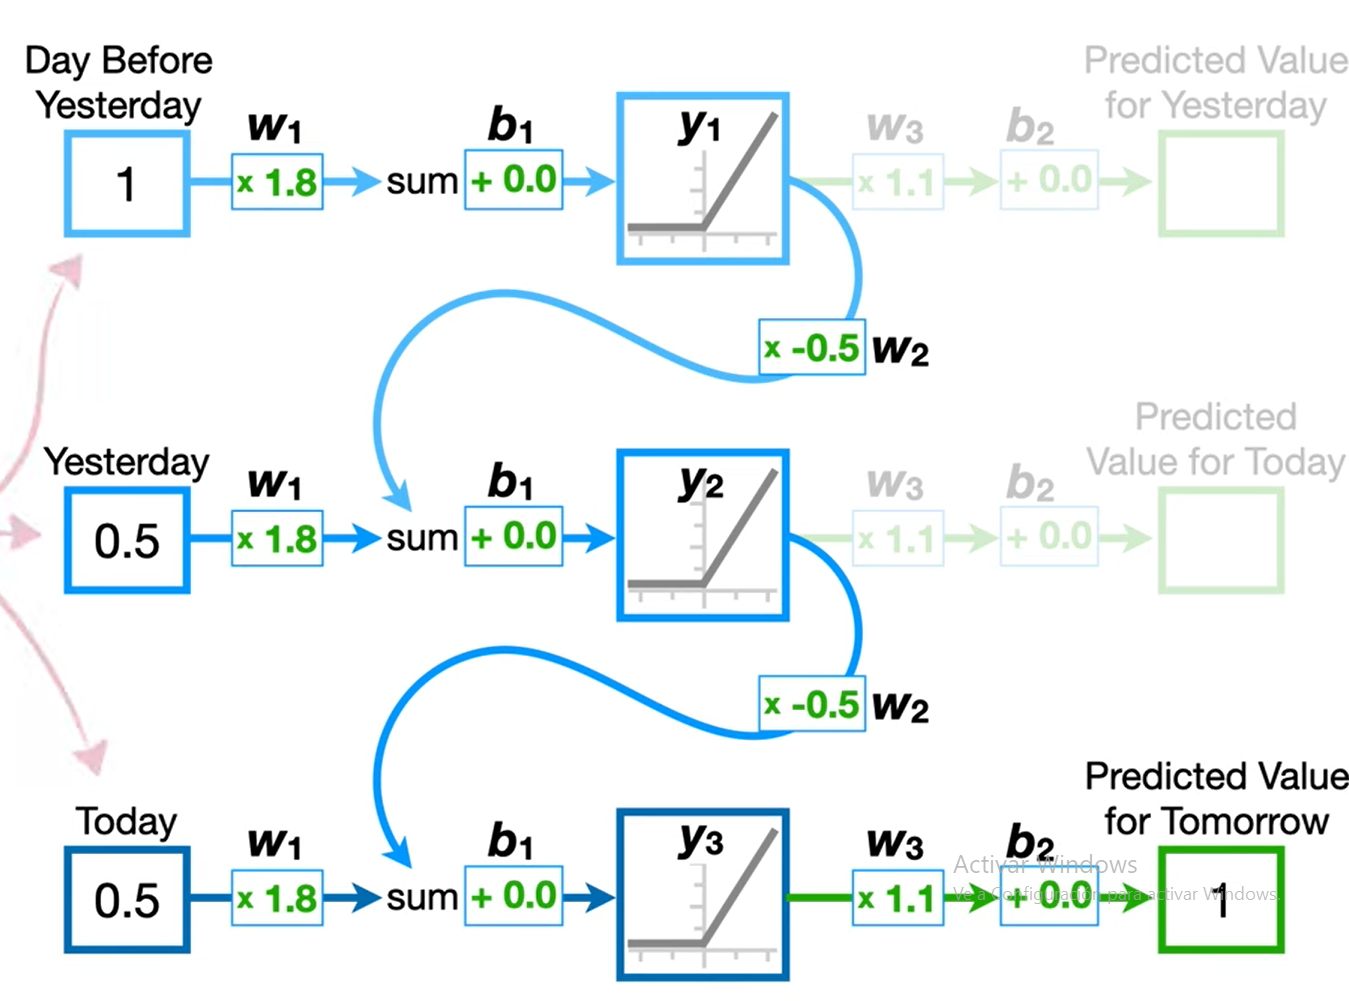
</div>

The first value is multiplied by a weight and also a bias is added. Then we apply an activation function (in this case 'Relu') and we use the result in the following step, thus creating a value that stores the history of the succession and uses it in the next value.

However, this model is not commonly used because it often leads to a problem:

#### **Vanishing/Exploding Gradients Problem**

The problem is in the training of the model. Remember that when optimizing the model, we seek to minimize the loss function using the gradient descent method. In the image above, let's look at the weight $w_2$ and suppose that we are using, as we have mentioned, the 'Relu' activation function. 

- If this weight is greater than 1, during backpropagation, the derivative of the loss function has the term $w_2 ^ n$ where $n$ is the number of samples. We therefore have a value that tends to infinity when n tends to infinity, making it difficult to take small steps by doing gradient descent. The **exploding gradient problem** happens when gradients grow exponentially, leading to unstable updates.

- On the other hand, if we set the condition that $w_2 < 1$, we have the problem that $w_2^n$ tends to $0$ when $n$ tends to infinity. The **vanishing gradient problem** is based on the fact that the gradient descent steps are so small that we reach the maximum number of iterations before reaching the optimal value.


For this reason we are using a different model:

## **Long Short Term Model (LSTM)**

**LSTMs** solve the issue by using gates (input, forget, and output) to control the flow of information through the network, allowing the network to "remember" important information over long time steps and preventing the gradient from either exploding or vanishing.

<div>
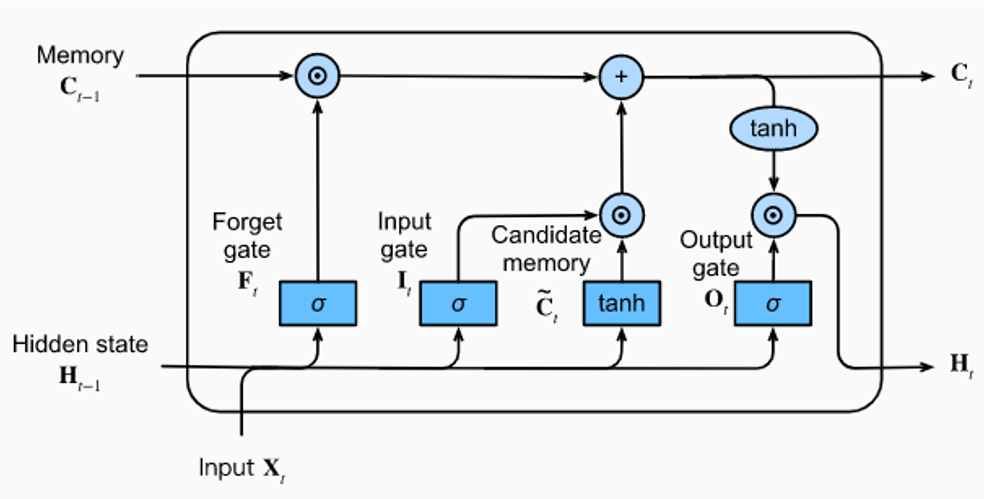
</div>


In [29]:
model = tf.keras.models.Sequential([

tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  #first layer is LSTM (50 neurons)

#return_sequences=True: return a complete sequence of outputs for each time step because we are using another LSTM Layer.


tf.keras.layers.Dropout(0.2), #avoid overfitting and make the network more robust

tf.keras.layers.LSTM(units=50, return_sequences=False),

tf.keras.layers.Dropout(0.2),

tf.keras.layers.Dense(units=1) #output layer

])


model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)


model.fit(X_train, y_train, epochs=20, batch_size=32)

C:\Users\emaie\Desktop\Porfolio2024\entorno\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - loss: 0.0494
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0045
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0033
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0030
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0023
Epoch 13/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021
Epoch 14/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022
Epoch 15/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020
Epo

Finally we make the predictions:

In [49]:
y_predicted = model.predict(X_test)

# Back to the original scale
y_predicted = scaler.inverse_transform(y_predicted)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Finally, we can do a plot visualizing the predictions:

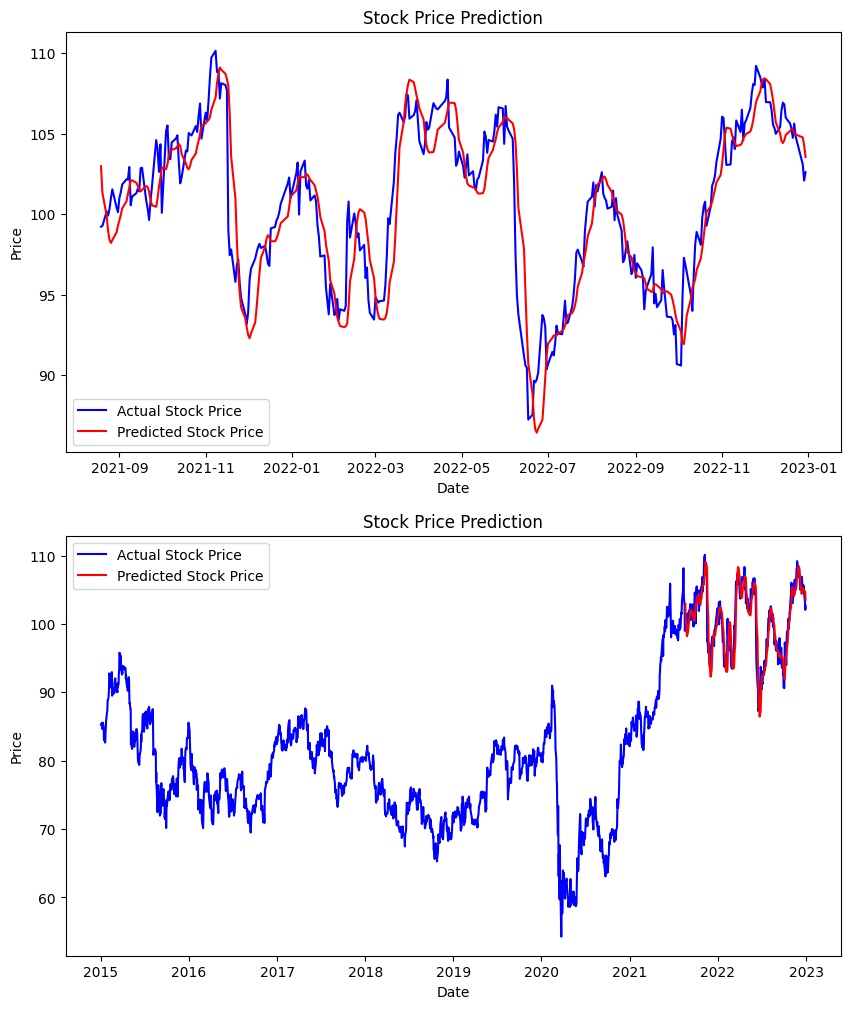

In [64]:

plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
plt.plot(close_prices.index[len(train_data) + 60:], y_test_original, color='blue', label='Actual Stock Price')
plt.plot(close_prices.index[len(train_data) + 60:], y_predicted, color='red', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()


plt.subplot(2,1,2)
plt.plot(close_prices.index, close_prices, color='blue', label='Actual Stock Price')
plt.plot(close_prices.index[len(train_data) + 60:], y_predicted, color='red', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()

plt.show()

In [57]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_original, y_predicted)
print('Mean Absolute Error (MAE): {}'.format(mse))

Mean Absolute Error (MAE): 4.729132045042059
